# Causal Model Fairness: A Case Study

In this notebook we'll use a dataset containing information of an infamously biased model: the COMPAS algorithm, which predicted recidivism risk for use in criminal sentencing. 

We will use the data containing COMPAS scores for violent recidivism, which ProPublica used to show that the algorithm was biased in different ways based on the defendant's race. Their work showed that COMPAS incorrectly gave high risk scores for black defendants at a much higher rate than white defendants.

Links and Further Reading:
* [The repo containing the data and original analysis code](https://github.com/propublica/compas-analysis/)
* [The story containing details of the findings](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)
* [A resource from ProPublica detailing their analytical approach](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)

In [ ]:
# %%capture
!pip install --upgrade numpy==1.23.5 dowhy seaborn statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.9/301.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.9/172.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.6/567.6 kB 24.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api
from dowhy import CausalModel
from math import exp
# plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

## Load Data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years-violent.csv')
df.shape

(4743, 54)

In [ ]:
df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid', 'two_year_recid.1'],
      dtype='object')

In [ ]:
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,two_year_recid.1
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,1
2,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,0
3,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0
4,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,0


## Data Preparation

This follows much of the same process used in [ProPublica's COMPAS notebook](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb). In that notebook, the authors seek to understand the extent to which the predicted COMPAAS score differs baased on the race of the defendant. They create and use the following columns:
* `c_charge_degree`: the degree of the charge (misdemeanor or felony)
* `age_cat`: a categorical encoding of the defendant's age
* `race`: the race of the defendant, which serves as the focus of this analysis
* `sex`: the sex of the defendant, encoded as `Female` and `Male`
* `priors_count`: the raw count of the defendant's prior convictions
* `two_year_recid`: whether the defendant actually reoffended in the two years following sentencing (i.e. the target which the model is trying to predict)
* `score_text`: the likelihood of reoffense predicted by the COMPAS model, bucketed into `Low`, `Medium`, and `High`
  * The ProPublica analysts binarize this into low scores vs. medium and high, which they use as the dependent variable in a GLM

In order to move forward with a similar analysis, we primarily need to filter out some problematic rows and create various features which are needed for the analysis. One of these new columns will be `correct`, a boolean value indicating whether the COMPAS model correctly identified an individual's risk of recidivism; defendants who are predicted as high risk but do not reoffend (i.e. _false positives_) are of particular interest in this context since they would receive stiffer sentences.

In [ ]:
fairness_df = df\
  .query("days_b_screening_arrest <= 30")\
  .query("days_b_screening_arrest >= -30")\
  .query("is_recid != -1")\
  .query("c_charge_degree != 'O'")\
  .query("score_text != 'N/A'")\
  .assign(predicted_recid = lambda x: (x.score_text != 'Low').astype(int),
          correct = lambda x: (x.predicted_recid == x.two_year_recid).astype(int),
          juvenile_offenses = lambda x: x.juv_fel_count + x.juv_misd_count + x.juv_other_count)\
  [['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 
    'priors_count', 'decile_score', 'juvenile_offenses',
    'is_recid', 'two_year_recid', 'predicted_recid', 'correct']]

fairness_df.shape

(4020, 13)

The way that the ProPublica analysts do this is essentially comparing the binarized score (Low vs. Med/High) with the `two_year_recid` value (whether the defendant reoffended within 2 years, as opposed to ever with `is_recid`)

In [ ]:
fairness_df['is_recid'].value_counts(dropna=False)

0    3187
1     833
Name: is_recid, dtype: int64

In [ ]:
fairness_df['two_year_recid'].value_counts(dropna=False)

0    3368
1     652
Name: two_year_recid, dtype: int64

In [ ]:
fairness_df['predicted_recid'].value_counts(dropna=False)

0    2566
1    1454
Name: predicted_recid, dtype: int64

In [ ]:
fairness_df['race'].value_counts(dropna=False)

African-American    1918
Caucasian           1459
Hispanic             355
Other                255
Asian                 26
Native American        7
Name: race, dtype: int64

As we get started, we'll filter to only Caucasian and African-American defendants

In [ ]:
fairness_df = fairness_df[fairness_df['race'].isin(['Caucasian', 'African-American'])]

## Exploratory Data Analysis

We can get started by viewing the distribution of our primary features: race, model output, model correctness, and actual recidivism.

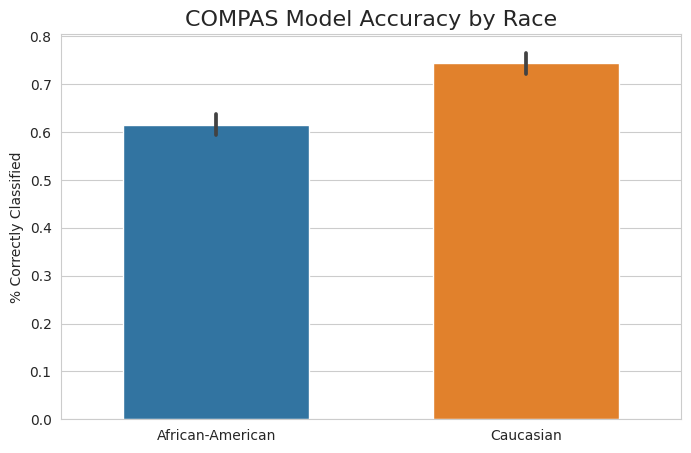

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=fairness_df, x="race", y="correct", width=0.6)
plt.title("COMPAS Model Accuracy by Race", fontsize=16)
plt.xlabel(None)
plt.ylabel("% Correctly Classified")
plt.show()

Right off the bat, we can see that the model is, on average, less accurate for African American defendants. This would be concerning enough on its own, but we want to look deeper.

How do model predictions differ by race?

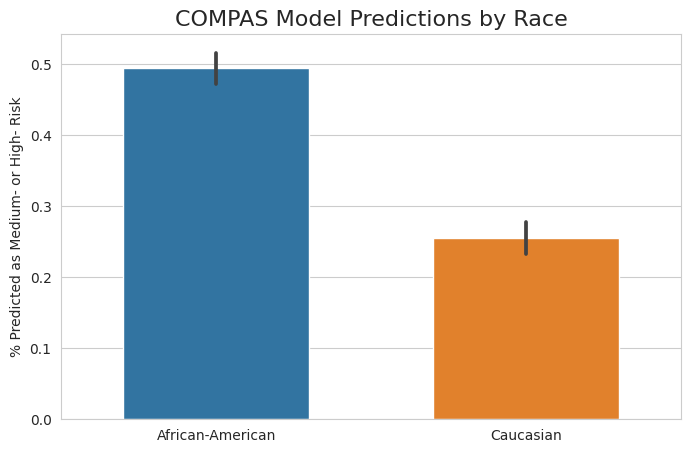

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=fairness_df, x="race", y="predicted_recid", width=0.6)
plt.title("COMPAS Model Predictions by Race", fontsize=16)
plt.xlabel(None)
plt.ylabel("% Predicted as Medium- or High- Risk")
plt.show()

We can see that the model produces higher predicted recidivism likelihood for African American defendants than Caucasians. Combining this with the lower accuracy for Black defendants paints a very concerning picture.

How does actual recidivism differ by race?

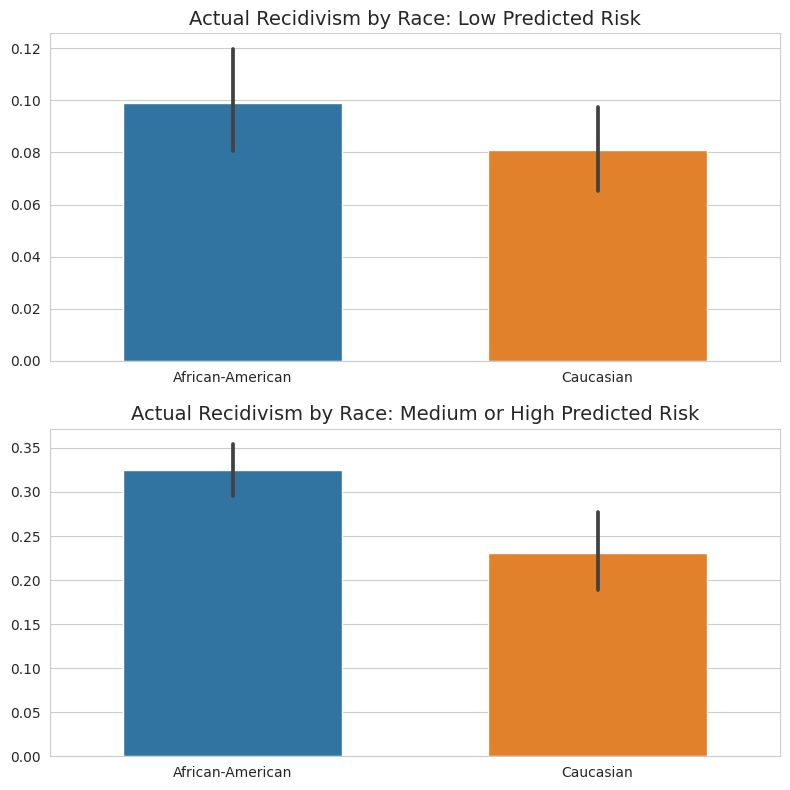

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(8, 8))

sns.barplot(data=fairness_df[fairness_df['predicted_recid'] == 0], 
            x="race", y="two_year_recid", width=0.6, ax=ax[0])
ax[0].set_title("Actual Recidivism by Race: Low Predicted Risk", fontsize=14)
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)

sns.barplot(data=fairness_df[fairness_df['predicted_recid'] == 1], 
            x="race", y="two_year_recid", width=0.6, ax=ax[1])
ax[1].set_title("Actual Recidivism by Race: Medium or High Predicted Risk", fontsize=14)
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)

plt.tight_layout(h_pad=1.5)
plt.show()

This shows us that actual recidivism over a 2 year period is slightly higher for Black defendants, however the impact is considerably smaller than the difference in either the model score or model accuracy (and may be affected by other genuine covariates, such as the nature of the offense). 

This sets the stage for a very interesting analysis: we'll be able to see whether the defendant's race actually plays an explanatory role in the predicted score and model performance. Let's jump in!

## Quantifying Fairness: Two Approaches
There are two primary ways to approach the question of model fairness, and both involve examining differences between a protected group and a baseline group. The first explores model _performance_ using standard meeasures such as classification accuracy. In the context of the COMPAS model, the high-level variation in model accuracy is as follows:


In [ ]:
fairness_df.groupby("race").agg({'correct':'mean'})

,correct
race,
African-American,0.615746
Caucasian,0.743660


The second approach to model fairness exaamines the difference in model _output_ directly (i.e. without regard to the actual outcome). In cases where model output is used directly in decision-making, exploring a protected category's influence on the model predictions can be a helpful way to quantify unfair bias. We can see the high-level disparity in predicted likelihood of reoffending here:

In [ ]:
fairness_df.groupby("race").agg({'predicted_recid':'mean'})

,predicted_recid
race,
African-American,0.494786
Caucasian,0.254969


Both methods highlight the possibility of some disparate treatment happening. However, there is no single correct approach to quantifying model fairness, and the decision will depend upon the context of the analysis. We will illustrate both approaches in the following sections

## Approach 1: Disparity in Model Accuracy
We will start by showing cauasal and non-causal methods of evaluating fairness in terms of model performance. For simplicity, we will use classification accuracy (i.e. whether a person's predicted recidivism risk matches the actual outcome). Other metrics, such as F1 score, could also be used.

### Non-Causal Methods

As discussed in the chapter, there are many ways to quantify model fairness without using causality. The most basic of these is to examine the high-level difference in accuracy, which we did in the previous section. This showed us that, at the most basic level, model accuracy is considerably lower for black defendants than white defendants. This difference is what Zhang and Bareinboim (2018) refer to as the _total variation_, or TV. 

The next level of non-causal fairness analysis is to control for relevant information. I'll do this in a similar way that the ProPublica analysts approach racial bias: I'll make a GLM that predicts whether the model correctly predicted an individual's outcome based on things like sex, age, race, prior convictions, and charge degree. This aligns most closely with the _conditional statistical parity_ definition, and we will use the coefficient for race to infer whether the model is unfair.

In [ ]:
glm_accuracy = smf.logit("""
correct ~ C(sex , Treatment(reference='Male'))
          + age_cat 
          + C(race, Treatment(reference='Caucasian')) 
          + c_charge_degree 
          + priors_count
""", data=fairness_df
).fit()

Optimization terminated successfully.
         Current function value: 0.597646
         Iterations 5


In [ ]:
glm_accuracy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                correct   No. Observations:                 3377
Model:                          Logit   Df Residuals:                     3370
Method:                           MLE   Df Model:                            6
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:                 0.05654
Time:                        19:40:43   Log-Likelihood:                -2018.3
converged:                       True   LL-Null:                       -2139.2
Covariance Type:            nonrobust   LLR p-value:                 2.213e-49
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         1.1314      0.085     13.250      0.000       0.964       1.299
C(sex, Treatment(reference='Male'))[T.Female]                    -0.1667      0.093     -1.795      0.073      -0.349       0.015
age_cat[T.Greater than 45]                                        0.7266      0.106      6.883      0.000       0.520       0.933
age_cat[T.Less than 25]                                          -0.6803      0.096     -7.095      0.000      -0.868      -0.492
C(race, Treatment(reference='Caucasian'))[T.African-American]    -0.3194      0.081     -3.953      0.000      -0.478      -0.161
c_charge_degree[T.M]                                              0.0676      0.080      0.847      0.397      -0.089       0.224
priors_count                                                     -0.0808      0.010     -8.373      0.000      -0.100      -0.062
=================================================================================================================================
"""

Judging by the coefficient for `race`, we can see a strong association between the defendant's race and whether the model correctly classifies the defendant.

We can restate this impact as a relative likelihood of being correctly classified:

In [ ]:
baseline = exp(1.1314) / (1 + exp(1.1314))

exp(-0.3914) / (1 - baseline + (baseline * exp(-0.3914)))

0.8953820774355417

This indicates that black defendants are less than 90% as likely to be correctly categorized as white defendants after controlling for other factors.

As an aside, the coefficient for an age of `Less than 25` also suggests the possibility of discriminatory effect:

In [ ]:
exp(-0.6803) / (1 - baseline + (baseline * exp(-0.6803)))

0.8079659069097392

This indicates that younger defendants are only ~80% as likely to be correctly categorized as defendants aged 25-45 after controlling for other factors.

### Causal Inference
We'll now use the `dowhy` library to frame this as a causal inference problem. This work will be similar to Example 5 in _Causal Fairness Analysis_ [(Plecko and Bareinboim, 2022)](https://causalai.net/r90.pdf), particularly leveraging the causal diagrams used there.

In [ ]:
def group_juvenile_offenses(count):
  if count == 0:
    return '0'
  elif count <= 2:
    return '1-2'
  else:
    return '3+'

def group_priors(count):
  if count == 0:
    return '0'
  elif count <= 3:
    return '1-3'
  elif count <= 8:
    return '4-8'
  else:
    return '9+'

fairness_df['juvenile_offenses_grouped'] = fairness_df['juvenile_offenses'].apply(group_juvenile_offenses)
fairness_df['priors_grouped'] = fairness_df['priors_count'].apply(group_priors)

In [ ]:
fairness_df.groupby('juvenile_offenses_grouped').agg({'predicted_recid':['count', 'mean']})

predicted_recid          
                                    count      mean
juvenile_offenses_grouped                          
0                                    3017  0.345376
1-2                                   277  0.732852
3+                                     83  0.915663

In [ ]:
fairness_df.groupby('priors_grouped', dropna=False).agg({'predicted_recid':['count', 'mean']})

predicted_recid          
                         count      mean
priors_grouped                          
0                         1293  0.253674
1-3                       1260  0.345238
4-8                        549  0.577413
9+                         275  0.876364

Let's define our causal graph using Graph Markup Language. What we want is something like this, where we have the following variables:
* X: race
* Y: COMPAS model accuracy
* Z1: gender
* Z2: age
* J: juvenile offense count
* P: prior offense count
* D: degree of charge

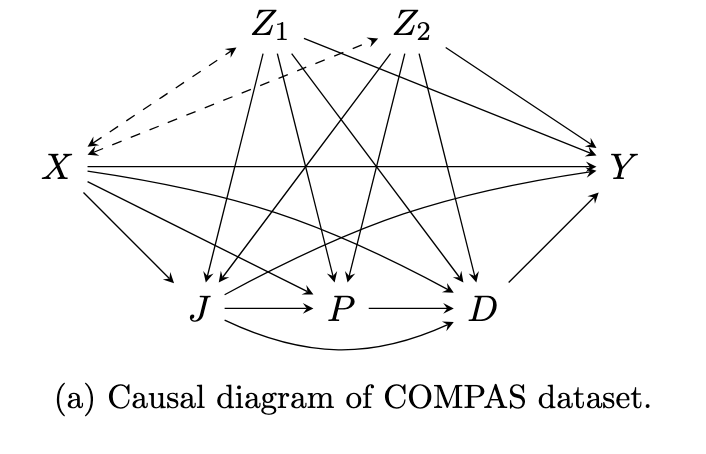

In [ ]:
causal_graph_accuracy = """
graph [
  comment "Causal graph for the COMPAS dataset"
  directed 1
  IsPlanar 1
  node [
    id "race"
    label "race"
  ]
  node [
    id "correct"
    label "correct"
  ]
  node [
    id "sex"
    label "sex"
  ]
  node [
    id "age_cat"
    label "age_cat"
  ]
  node [
    id "juvenile_offenses_grouped"
    label "juvenile_offenses_grouped"
  ]
  node [
    id "priors_grouped"
    label "priors_grouped"
  ]
  node [
    id "c_charge_degree"
    label "c_charge_degree"
  ]
  edge [
    source "race"
    target "correct"
    label "Discriminatory Effect"
  ]
  edge [
    source "race"
    target "juvenile_offenses_grouped"
    label "Edge from race to juvenile offense count"
  ]
  edge [
    source "race"
    target "priors_grouped"
    label "Edge from race to prior offense count"
  ]
  edge [
    source "race"
    target "c_charge_degree"
    label "Edge from race to charge degree"
  ]
  edge [
    source "sex"
    target "correct"
    label "Edge from sex to outcome"
  ]
  edge [
    source "sex"
    target "juvenile_offenses_grouped"
    label "Edge from sex to juvenile offense count"
  ]
  edge [
    source "sex"
    target "priors_grouped"
    label "Edge from sex to prior offense count"
  ]
  edge [
    source "sex"
    target "c_charge_degree"
    label "Edge from sex to charge degree"
  ]
  edge [
    source "age_cat"
    target "correct"
    label "Edge from age to outcome"
  ]
  edge [
    source "age_cat"
    target "juvenile_offenses_grouped"
    label "Edge from age to juvenile offense count"
  ]
  edge [
    source "age_cat"
    target "priors_grouped"
    label "Edge from age to prior offense count"
  ]
  edge [
    source "age_cat"
    target "c_charge_degree"
    label "Edge from age to charge degree"
  ]

  edge [
    source "juvenile_offenses_grouped"
    target "priors_grouped"
    label "Edge from juvenile count to prior count"
  ]
  edge [
    source "juvenile_offenses_grouped"
    target "c_charge_degree"
    label "Edge from juvenile count to charge degree"
  ]
  edge [
    source "juvenile_offenses_grouped"
    target "correct"
    label "Edge from juvenile count to outcome"
  ]
  edge [
    source "priors_grouped"
    target "c_charge_degree"
    label "Edge from prior count to charge degree"
  ]
  edge [
    source "c_charge_degree"
    target "correct"
    label "Edge from charge degree to outcome"
  ]
]
"""

That's a lot of text, but we now have a causal graph to use in `dowhy`

We need to encode `race` as a numeric factor prior to using `dowhy`, so we'll do that here

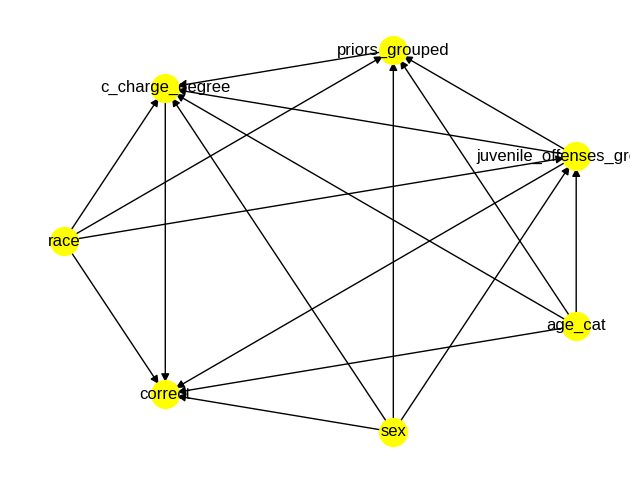

In [ ]:
causal_df = fairness_df\
  .assign(race=lambda x: x.race.map({'Caucasian':0, 'African-American':1}))

causal_model_accuracy = CausalModel(data=causal_df, treatment="race", outcome="correct", graph=causal_graph_accuracy)
causal_model_accuracy.view_model()

In [ ]:
identified_estimand_accuracy = causal_model_accuracy.identify_effect()
print(identified_estimand_accuracy)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d               
───────(E[correct])
d[race]            
Estimand assumption 1, Unconfoundedness: If U→{race} and U→correct then P(correct|race,,U) = P(correct|race,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
estimate_accuracy = causal_model_accuracy.estimate_effect(
    identified_estimand_accuracy,
    control_value=0, 
    treatment_value=1,
    method_name="backdoor.generalized_linear_model",
    method_params={'glm_family':statsmodels.api.families.Binomial()}
)

estimate_accuracy.value

-0.11602012172673581

In [ ]:
estimate_accuracy.get_confidence_intervals()

(-0.14276289228157402, -0.08816615398480188)

In [ ]:
estimate_accuracy.test_stat_significance()

{'p_value': (0, 0.001)}

In [ ]:
estimate_accuracy.interpret()

Increasing the treatment variable(s) [race] from 0 to 1 causes an increase of -0.11602012172673581 in the expected value of the outcome [correct], over the data distribution/population represented by the dataset.


This indicates that there is a fairly strong causal link between a defendant's race and whether they are correctly categorized as high-risk by the COMPAS model. In fact, this shows that the causal effect of a defendant being Black is a reduction of 11.6 percentage points in expected accuracy. This means that **the causal estimand is slightly larger** than the non-causal measure.

The `dowhy` library also contains tools for refuting an estimate of causal impact. These techniques use the relationships in the causal graph to simulate various changes which test the robustness of the estimate provided by the data.

The first refutation we'll use is a random common cause. This method adds a randomly drawn covariate to the data and recalculates the estimate -- ideally, this will not alter our estimate.

In [ ]:
res_random=causal_model_accuracy.refute_estimate(identified_estimand_accuracy, 
                                                 estimate_accuracy, 
                                                 method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:-0.11602012172673581
New effect:-0.11601074267629269
p value:0.92



As we can see, the "refuted" result is not very different from our original estimate. This gives us confidence that our assumptions were correct!

The next refutation method we'll use is a placebo treatment: this technique randomly assigns a covariate as a treatment and then recalculates the estimate. The effect of the placebo should be near zero:

In [ ]:
res_placebo=causal_model_accuracy.refute_estimate(identified_estimand_accuracy, 
                                                  estimate_accuracy,
                                                  method_name="placebo_treatment_refuter")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.11602012172673581
New effect:0.0033582658759722128
p value:0.72



Once again, we get a good result from the refutation

We have one more refutation technique to use in this example: this method splits our data into random subsets and sees how the causal estimates change between subsets. The new effect will hopefully be similar to our original:

In [ ]:
res_subset=causal_model_accuracy.refute_estimate(identified_estimand_accuracy, 
                                                 estimate_accuracy,
                                                 method_name="data_subset_refuter", 
                                                 subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-0.11602012172673581
New effect:-0.11539297201511677
p value:0.9



That looks good! We can see that our original estimate is robust to all 3 refutation methods.

## Approach 2: Disparity in Model Predictions

This section uses the same tools to assess fairness from the perspective of model predictions. Since COMPAS predictions were used in sentencing, any undue influence stemming from race could have significant and unfair impacts on a defendant's life. 

As we saw during exploratory analysis, the average prediction is substantially higher for African American defendants than Caucasian defendants

In [ ]:
fairness_df.groupby("race").agg({'predicted_recid':'mean'})

,predicted_recid
race,
African-American,0.494786
Caucasian,0.254969


### Non-Causal Methods

We will again use a GLM to provide the non-causal estimate of the racial bias from COMPAS. 

In [ ]:
glm_prediction = smf.logit("""
predicted_recid ~ C(sex , Treatment(reference='Male'))
          + age_cat 
          + C(race, Treatment(reference='Caucasian')) 
          + c_charge_degree 
          + priors_count
""", data=fairness_df
).fit()

glm_prediction.summary()

Optimization terminated successfully.
         Current function value: 0.510457
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        predicted_recid   No. Observations:                 3377
Model:                          Logit   Df Residuals:                     3370
Method:                           MLE   Df Model:                            6
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:                  0.2373
Time:                        19:44:25   Log-Likelihood:                -1723.8
converged:                       True   LL-Null:                       -2260.1
Covariance Type:            nonrobust   LLR p-value:                1.743e-228
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        -1.5842      0.096    -16.471      0.000      -1.773      -1.396
C(sex, Treatment(reference='Male'))[T.Female]                     0.2352      0.101      2.325      0.020       0.037       0.434
age_cat[T.Greater than 45]                                       -1.4516      0.131    -11.095      0.000      -1.708      -1.195
age_cat[T.Less than 25]                                           1.3943      0.103     13.600      0.000       1.193       1.595
C(race, Treatment(reference='Caucasian'))[T.African-American]     0.5722      0.087      6.592      0.000       0.402       0.742
c_charge_degree[T.M]                                             -0.1823      0.087     -2.090      0.037      -0.353      -0.011
priors_count                                                      0.3123      0.016     19.330      0.000       0.281       0.344
=================================================================================================================================
"""

We can see a very strong coefficient for race in this model. In terms of relative probability:

In [ ]:
baseline = exp(-1.5842) / (1 + exp(-1.5842))

exp(0.5722) / (1 - baseline + (baseline * exp(0.5722)))

1.5663120391957737

This says that African American defendants have a **56.6% higher** likelihood of being predicted as medium/high risk of recidivism after controlling for other features.

### Causal Inference

We can again use `dowhy` to perform causal inference on the disparity in model predictions. We'll use the same causal graph as before, with the exception of the outcome being predicted recidivism rather than an indicator of model correctness.

In [ ]:
causal_graph_prediction = """
graph [
  comment "Causal graph for the COMPAS dataset"
  directed 1
  IsPlanar 1
  node [
    id "race"
    label "race"
  ]
  node [
    id "predicted_recid"
    label "predicted_recid"
  ]
  node [
    id "sex"
    label "sex"
  ]
  node [
    id "age_cat"
    label "age_cat"
  ]
  node [
    id "juvenile_offenses_grouped"
    label "juvenile_offenses_grouped"
  ]
  node [
    id "priors_grouped"
    label "priors_grouped"
  ]
  node [
    id "c_charge_degree"
    label "c_charge_degree"
  ]
  edge [
    source "race"
    target "predicted_recid"
    label "Discriminatory Effect"
  ]
  edge [
    source "race"
    target "juvenile_offenses_grouped"
    label "Edge from race to juvenile offense count"
  ]
  edge [
    source "race"
    target "priors_grouped"
    label "Edge from race to prior offense count"
  ]
  edge [
    source "race"
    target "c_charge_degree"
    label "Edge from race to charge degree"
  ]
  edge [
    source "sex"
    target "predicted_recid"
    label "Edge from sex to outcome"
  ]
  edge [
    source "sex"
    target "juvenile_offenses_grouped"
    label "Edge from sex to juvenile offense count"
  ]
  edge [
    source "sex"
    target "priors_grouped"
    label "Edge from sex to prior offense count"
  ]
  edge [
    source "sex"
    target "c_charge_degree"
    label "Edge from sex to charge degree"
  ]
  edge [
    source "age_cat"
    target "predicted_recid"
    label "Edge from age to outcome"
  ]
  edge [
    source "age_cat"
    target "juvenile_offenses_grouped"
    label "Edge from age to juvenile offense count"
  ]
  edge [
    source "age_cat"
    target "priors_grouped"
    label "Edge from age to prior offense count"
  ]
  edge [
    source "age_cat"
    target "c_charge_degree"
    label "Edge from age to charge degree"
  ]

  edge [
    source "juvenile_offenses_grouped"
    target "priors_grouped"
    label "Edge from juvenile count to prior count"
  ]
  edge [
    source "juvenile_offenses_grouped"
    target "c_charge_degree"
    label "Edge from juvenile count to charge degree"
  ]
  edge [
    source "juvenile_offenses_grouped"
    target "predicted_recid"
    label "Edge from juvenile count to outcome"
  ]
  edge [
    source "priors_grouped"
    target "c_charge_degree"
    label "Edge from prior count to charge degree"
  ]
  edge [
    source "c_charge_degree"
    target "predicted_recid"
    label "Edge from charge degree to outcome"
  ]
]
"""

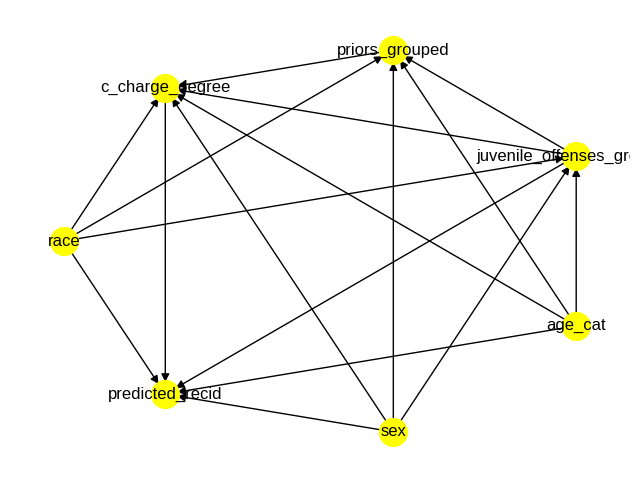

In [ ]:
causal_model_prediction = CausalModel(data=causal_df, 
                     treatment="race", 
                     outcome="predicted_recid", graph=causal_graph_prediction)
causal_model_prediction.view_model()

In [ ]:
identified_estimand_prediction = causal_model_prediction.identify_effect()
print(identified_estimand_prediction)

estimate_prediction = causal_model_prediction.estimate_effect(
    identified_estimand_prediction,
    control_value=0, 
    treatment_value=1,
    method_name="backdoor.generalized_linear_model",
    method_params={'glm_family':statsmodels.api.families.Binomial()}
)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                       
───────(E[predicted_recid])
d[race]                    
Estimand assumption 1, Unconfoundedness: If U→{race} and U→predicted_recid then P(predicted_recid|race,,U) = P(predicted_recid|race,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
estimate_prediction.value

0.21805313041129498

The causal effect here is still very large, but it is significantly smaller than the non-causal estimate, which differs from what we saw in the analysis of model accuracy. This is saying that African American defendants have a **21.8% greater chance** of being classified as high risk, and that this difference is **due directly to their race**. Again, the use of causal methods allows us to attribute such disparity to discriminatory effect rather than a coincidental association.

In [ ]:
estimate_prediction.get_confidence_intervals()

(0.1958614085901236, 0.2421813251125215)

In [ ]:
estimate_prediction.interpret()

Increasing the treatment variable(s) [race] from 0 to 1 causes an increase of 0.21805313041129498 in the expected value of the outcome [predicted_recid], over the data distribution/population represented by the dataset.


## Conclusion

This case study has provided a walkthrough of estimating model fairness using both causal and non-causal methods. We have seen that these methods may occasionlly produce similar results, and they may differ. However, only causal methods allow us to frame the findings as direct causal effect.

## NOTES FOR WRITE-UP

* Give context
* Put high-level plots in as-is
* Describe difference in two approaches
* Table of effects like this:

|Outcome|Causal Effect|Non-Causal Effect|
|:--:|:-:|:-:|
| Predicted recidivism | +21.8%| +56.6% |
| Model accuracy | -11.6% | -10.5%|